In [1]:
from collections import defaultdict
import glob
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
pwd

'/home/olga/code/kh-analysis--brawand2011-extract-coding/notebooks'

In [3]:
folder = '/home/olga/googledrive/brawand2011/data/kmermaid/results_peptide7/extract_coding'
classification_percentages_metadata = pd.read_csv(f'{folder}/classification_percentages_metadata.csv')
print(classification_percentages_metadata.shape)
classification_percentages_metadata.head()

(147, 16)


,Non-coding,Coding,No translation frames without stop codons,All translations shorter than peptide k-mer size + 1,Read length was shorter than 3 * peptide k-mer size,Low complexity peptide in protein encoding,filename,sample_id,sra_id,geo_id,species_abbrev,tissue_abbrev,sex,replicate,species,tissue
0,68.549280,26.416538,4.030022,0.872370,0.075918,0.055873,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306802_GSM752655_ggo_cb_F_1,SRR306802,GSM752655,ggo,cb,F,1,Gorilla,Cerebellum
1,76.458843,18.913639,3.486677,0.801294,0.064244,0.275304,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306765_GSM752619_mmu_cb_M_2,SRR306765,GSM752619,mmu,cb,M,2,Mouse,Cerebellum
2,78.203007,16.819733,4.308748,0.599139,0.042650,0.026723,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306782_GSM752636_mml_ht_F_1,SRR306782,GSM752636,mml,ht,F,1,Macaque,Heart
3,78.245375,15.101219,5.841887,0.738069,0.015459,0.057990,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306750_GSM752598_mdo_ht_M_1,SRR306750,GSM752598,mdo,ht,M,1,Opossum,Heart
4,86.181560,9.365462,3.264713,1.088898,0.039388,0.059979,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306753_GSM752606_mdo_lv_F_1,SRR306753,GSM752606,mdo,lv,F,1,Opossum,Liver


In [4]:
base_folder = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq'
globber = f'{base_folder}/*/*/rseqc/read_distribution/*'
glob.glob(globber)

['/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306850_GSM752701_hsa_ht_M_2Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306846_GSM752698_hsa_cb_M_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306856_GSM752706_hsa_lv_M_2Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306844_GSM752697_hsa_cb_F_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/

Steal [MultiQC's](https://github.com/ewels/MultiQC/blob/master/multiqc/modules/rseqc/read_distribution.py) parsing

In [5]:
import re

first_regexes = {
    'total_reads': r"Total Reads\s+(\d+)\s*",
    'total_tags': r"Total Tags\s+(\d+)\s*",
    'total_assigned_tags': r"Total Assigned Tags\s+(\d+)\s*",
}
second_regexes = {
    'cds_exons': r"CDS_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    '5_utr_exons': r"5'UTR_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    '3_utr_exons': r"3'UTR_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'introns': r"Introns\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_1kb': r"TSS_up_1kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_5kb': r"TSS_up_5kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_10kb': r"TSS_up_10kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_1kb': r"TES_down_1kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_5kb': r"TES_down_5kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_10kb': r"TES_down_10kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
}

def parse_rseqc_read_distribution(filename):
    sample_id = os.path.basename(filename).split('Aligned.sortedByCoord.out.read_distribution.txt')[0]
    
    # If there is a double number at the end, then this was a paired-end 
    # read set and need to remove the last _1
    if re.search(r'\d_\d', sample_id) is not None:
        sample_id = re.findall('(\w+)_\d', sample_id)[0]
    d = dict()
    with open(filename) as f:
        file_content = f.read()
        for k, r in first_regexes.items():
            r_search = re.search(r, file_content, re.MULTILINE)
            if r_search:
                d[k] = int(r_search.group(1))
        for k, r in second_regexes.items():
            r_search = re.search(r, file_content, re.MULTILINE)
            if r_search:
                d['{}_total_bases'.format(k)] = int(r_search.group(1))
                d['{}_tag_count'.format(k)] = int(r_search.group(2))
                d['{}_tags_kb'.format(k)] = float(r_search.group(3))

        d['other_intergenic_tag_count'] = d['total_tags']-d['total_assigned_tags']

        # Calculate some percentages for parsed file
        if 'total_tags' in d:
            t = float(d['total_tags'])
            pcts = dict()
            for k in d:
                if k.endswith('_tag_count'):
                    pk = '{}_tag_pct'.format(k[:-10])
                    pcts[pk] = (float(d[k]) / t)*100.0
            d.update(pcts)
            
    series = pd.Series(d, name=sample_id)
    return series

filename = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/chimpanzee/paired_end/rseqc/read_distribution/SRR306816_GSM752669_ptr_br_M_5_1Aligned.sortedByCoord.out.read_distribution.txt'
parse_rseqc_read_distribution(filename)

total_reads                   3.751575e+07
total_tags                    4.286295e+07
total_assigned_tags           3.564938e+07
cds_exons_total_bases         8.808513e+07
cds_exons_tag_count           2.128516e+07
cds_exons_tags_kb             2.416400e+02
5_utr_exons_total_bases       6.300107e+06
5_utr_exons_tag_count         3.360410e+05
5_utr_exons_tags_kb           5.334000e+01
3_utr_exons_total_bases       2.959627e+07
3_utr_exons_tag_count         7.649711e+06
3_utr_exons_tags_kb           2.584700e+02
introns_total_bases           1.418158e+09
introns_tag_count             4.878900e+06
introns_tags_kb               3.440000e+00
tss_up_1kb_total_bases        2.880640e+07
tss_up_1kb_tag_count          5.329400e+04
tss_up_1kb_tags_kb            1.850000e+00
tss_up_5kb_total_bases        1.301524e+08
tss_up_5kb_tag_count          6.452800e+05
tss_up_5kb_tags_kb            4.960000e+00
tss_up_10kb_total_bases       2.352638e+08
tss_up_10kb_tag_count         9.056750e+05
tss_up_10kb

In [6]:
base_folder = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq'
globber = f'{base_folder}/*/*/rseqc/read_distribution/*'

seriess = []

for filename in glob.iglob(globber):
    series = parse_rseqc_read_distribution(filename)
    seriess.append(series)
rseqc_read_distributions = pd.DataFrame(seriess)
print(rseqc_read_distributions.shape)
rseqc_read_distributions.head()

(101, 45)


,total_reads,total_tags,total_assigned_tags,cds_exons_total_bases,cds_exons_tag_count,cds_exons_tags_kb,5_utr_exons_total_bases,5_utr_exons_tag_count,5_utr_exons_tags_kb,3_utr_exons_total_bases,...,5_utr_exons_tag_pct,3_utr_exons_tag_pct,introns_tag_pct,tss_up_1kb_tag_pct,tss_up_5kb_tag_pct,tss_up_10kb_tag_pct,tes_down_1kb_tag_pct,tes_down_5kb_tag_pct,tes_down_10kb_tag_pct,other_intergenic_tag_pct
SRR306850_GSM752701_hsa_ht_M_2,21292867.0,25258488.0,24387237.0,97553390.0,19675431.0,201.69,6708876.0,376547.0,56.13,32534150.0,...,1.490774,11.312506,5.375496,0.079280,0.133900,0.165841,0.118602,0.252719,0.309730,3.449339
SRR306846_GSM752698_hsa_cb_M_1,15800648.0,18379213.0,17615565.0,97553390.0,12662565.0,129.80,6708876.0,196081.0,29.23,32534150.0,...,1.066863,15.304480,9.503900,0.103867,0.230325,0.325966,0.218132,0.578784,0.747714,4.154955
SRR306838_GSM752691_hsa_br_F_1,780690.0,889131.0,867476.0,97553390.0,537910.0,5.51,6708876.0,4158.0,0.62,32534150.0,...,0.467648,26.638932,8.776997,0.058821,0.188049,0.274425,0.299169,0.725877,0.908078,2.435524
SRR306856_GSM752706_hsa_lv_M_2,20479674.0,25412159.0,24423554.0,97553390.0,20272780.0,207.81,6708876.0,244771.0,36.48,32534150.0,...,0.963204,8.959223,5.672659,0.069628,0.152541,0.290511,0.170481,0.361547,0.448215,3.890283
SRR306844_GSM752697_hsa_cb_F_1,26696068.0,30804199.0,29400439.0,97553390.0,20372273.0,208.83,6708876.0,514939.0,76.75,32534150.0,...,1.671652,12.543702,13.763228,0.142536,0.290792,0.399877,0.244973,0.686747,0.929773,4.557041


In [7]:
rseqc_read_distributions

,total_reads,total_tags,total_assigned_tags,cds_exons_total_bases,cds_exons_tag_count,cds_exons_tags_kb,5_utr_exons_total_bases,5_utr_exons_tag_count,5_utr_exons_tags_kb,3_utr_exons_total_bases,...,5_utr_exons_tag_pct,3_utr_exons_tag_pct,introns_tag_pct,tss_up_1kb_tag_pct,tss_up_5kb_tag_pct,tss_up_10kb_tag_pct,tes_down_1kb_tag_pct,tes_down_5kb_tag_pct,tes_down_10kb_tag_pct,other_intergenic_tag_pct
SRR306850_GSM752701_hsa_ht_M_2,21292867.0,25258488.0,24387237.0,97553390.0,19675431.0,201.69,6708876.0,376547.0,56.13,32534150.0,...,1.490774,11.312506,5.375496,0.079280,0.133900,0.165841,0.118602,0.252719,0.309730,3.449339
SRR306846_GSM752698_hsa_cb_M_1,15800648.0,18379213.0,17615565.0,97553390.0,12662565.0,129.80,6708876.0,196081.0,29.23,32534150.0,...,1.066863,15.304480,9.503900,0.103867,0.230325,0.325966,0.218132,0.578784,0.747714,4.154955
SRR306838_GSM752691_hsa_br_F_1,780690.0,889131.0,867476.0,97553390.0,537910.0,5.51,6708876.0,4158.0,0.62,32534150.0,...,0.467648,26.638932,8.776997,0.058821,0.188049,0.274425,0.299169,0.725877,0.908078,2.435524
SRR306856_GSM752706_hsa_lv_M_2,20479674.0,25412159.0,24423554.0,97553390.0,20272780.0,207.81,6708876.0,244771.0,36.48,32534150.0,...,0.963204,8.959223,5.672659,0.069628,0.152541,0.290511,0.170481,0.361547,0.448215,3.890283
SRR306844_GSM752697_hsa_cb_F_1,26696068.0,30804199.0,29400439.0,97553390.0,20372273.0,208.83,6708876.0,514939.0,76.75,32534150.0,...,1.671652,12.543702,13.763228,0.142536,0.290792,0.399877,0.244973,0.686747,0.929773,4.557041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR306806_GSM752659_ggo_kd_F_1,15476916.0,17771621.0,16367107.0,36343669.0,10792774.0,296.96,3769623.0,211906.0,56.21,14743451.0,...,1.192384,12.565685,9.969468,0.395068,1.119887,1.940313,2.646213,5.101583,5.698636,7.903128
SRR306810_GSM752663_ggo_ts_M_1,16688833.0,19713095.0,17807319.0,36343669.0,11912757.0,327.78,3769623.0,380205.0,100.86,14743451.0,...,1.928693,9.347096,11.392584,0.803674,1.899965,2.811436,1.674821,3.661170,4.421949,9.667564
SRR306808_GSM752661_ggo_lv_F_1,26587518.0,31747775.0,29907578.0,36343669.0,20611432.0,567.13,3769623.0,314366.0,83.39,14743451.0,...,0.990199,12.316035,10.613279,0.292074,0.859418,1.352687,1.978028,3.586919,4.009053,5.796302
SRR306800_GSM752653_ggo_br_F_1,29318040.0,34161434.0,31243414.0,36343669.0,19768139.0,543.92,3769623.0,461573.0,122.45,14743451.0,...,1.351152,13.453466,10.472523,0.518228,1.288207,1.973503,2.010047,5.365029,6.340671,8.541855


In [8]:
rseqc_read_distributions['cds_exons_tag_pct']

SRR306850_GSM752701_hsa_ht_M_2    77.896314
SRR306846_GSM752698_hsa_cb_M_1    68.896122
SRR306838_GSM752691_hsa_br_F_1    60.498397
SRR306856_GSM752706_hsa_lv_M_2    79.775906
SRR306844_GSM752697_hsa_cb_F_1    66.134727
                                    ...    
SRR306806_GSM752659_ggo_kd_F_1    60.730386
SRR306810_GSM752663_ggo_ts_M_1    60.430678
SRR306808_GSM752661_ggo_lv_F_1    64.922446
SRR306800_GSM752653_ggo_br_F_1    57.866830
SRR306801_GSM752654_ggo_br_M_1    57.816875
Name: cds_exons_tag_pct, Length: 101, dtype: float64

In [9]:
pattern = r'\d_\d'
%timeit re.findall(pattern, "SRR306814_GSM752667_ptr_br_M_3_1")

2.13 µs ± 21.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
pattern2 = '(\w+)_1'
re.findall(pattern2, "SRR306814_GSM752667_ptr_br_M_3_1")

['SRR306814_GSM752667_ptr_br_M_3']

In [11]:
%timeit re.search(pattern, "SRR306814_GSM752667_ptr_br_M_3_1")

2.03 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
kmermaid_with_cds = classification_percentages_metadata.join(rseqc_read_distributions['cds_exons_tag_pct'], 
                                         on='sample_id', how='inner')
print(kmermaid_with_cds.shape)
kmermaid_with_cds.head()

(100, 17)


,Non-coding,Coding,No translation frames without stop codons,All translations shorter than peptide k-mer size + 1,Read length was shorter than 3 * peptide k-mer size,Low complexity peptide in protein encoding,filename,sample_id,sra_id,geo_id,species_abbrev,tissue_abbrev,sex,replicate,species,tissue,cds_exons_tag_pct
0,68.549280,26.416538,4.030022,0.872370,0.075918,0.055873,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306802_GSM752655_ggo_cb_F_1,SRR306802,GSM752655,ggo,cb,F,1,Gorilla,Cerebellum,52.123023
1,76.458843,18.913639,3.486677,0.801294,0.064244,0.275304,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306765_GSM752619_mmu_cb_M_2,SRR306765,GSM752619,mmu,cb,M,2,Mouse,Cerebellum,61.394061
2,78.203007,16.819733,4.308748,0.599139,0.042650,0.026723,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306782_GSM752636_mml_ht_F_1,SRR306782,GSM752636,mml,ht,F,1,Macaque,Heart,44.395308
5,63.434188,31.277348,4.229160,1.007798,0.019810,0.031696,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306846_GSM752698_hsa_cb_M_1,SRR306846,GSM752698,hsa,cb,M,1,Human,Cerebellum,68.896122
6,62.385552,31.593917,5.249130,0.697215,0.056313,0.017873,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306809_GSM752662_ggo_lv_M_1,SRR306809,GSM752662,ggo,lv,M,1,Gorilla,Liver,63.778371


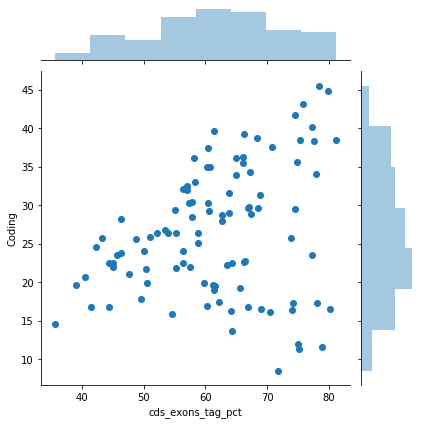

In [13]:
sns.jointplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds)

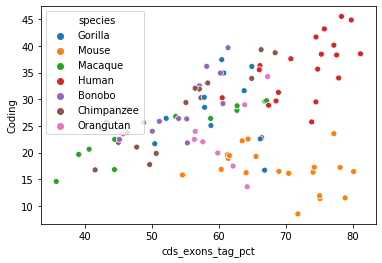

In [14]:
sns.scatterplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

In [15]:
kmermaid_with_cds['cds_exons_tag_pct'].corr(kmermaid_with_cds['Coding'])

0.2744744597504502

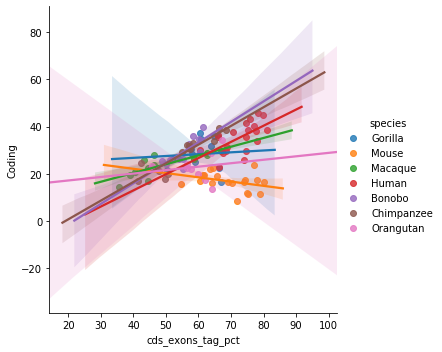

In [16]:
sns.lmplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

In [23]:
# sns.lmplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species', robust=True)

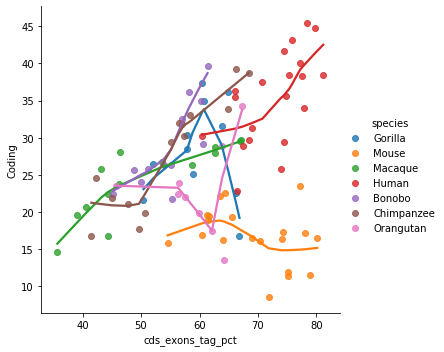

In [20]:
sns.lmplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species', lowess=True)

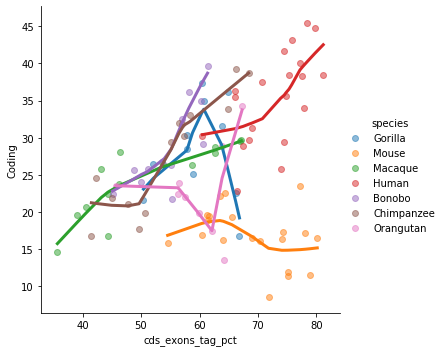

In [27]:
sns.lmplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species', 
           lowess=True, scatter_kws=dict(alpha=0.5), line_kws=dict(linewidth=3))

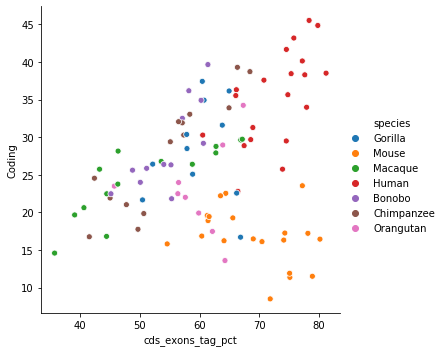

In [17]:
sns.relplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

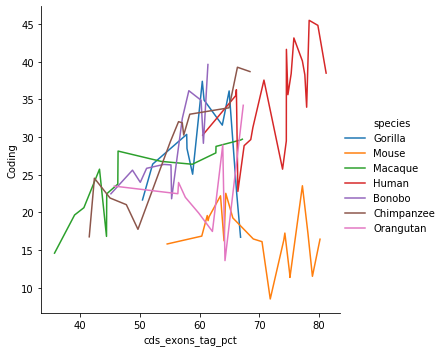

In [21]:
sns.relplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species', kind='line')